# Smart Butcher KI-System 🧠🥩

Dieses Notebook zeigt ein vollständiges **KI-Projekt für eine Metzgerei / ein kleines Lebensmittelgeschäft (KMU)** mit zwei Modulen:

1. **Bedarfsprognose für Fleischprodukte** (mit 10+ Produkten)
2. **Predictive Maintenance für Kühlvitrinen und Fleischmaschinen** 🔧

---

In [1]:
# Zelle 1: Bibliotheken importieren

import numpy as np
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, r2_score, confusion_matrix, classification_report

import warnings
warnings.filterwarnings('ignore')

# Plot-Styling
sns.set_style("darkgrid")
plt.rcParams['figure.figsize'] = (14, 6)
plt.rcParams['font.size'] = 10

print("✅ Alle Bibliotheken erfolgreich importiert!")

✅ Alle Bibliotheken erfolgreich importiert!


## Modul 1 – Bedarfsprognose für Fleischprodukte

Zunächst erzeugen wir einen **synthetischen Datensatz** für 1 Jahr.
Die Metzgerei verkauft 10+ verschiedene Fleischprodukte mit unterschiedlichen Absatzmustern.

### Produkte der Metzgerei:
1. Schweineschnitzel
2. Rinderfilet
3. Hähnchenbrust
4. Bratwurst (Wurst)
5. Leberwurst
6. Mortadella
7. Rindergeschnetzeltes
8. Lammkoteletts
9. Hackfleisch (gemischt)
10. Schweinebauch (Speck)
11. Putenschnitzel
12. Kalbsschnitzel

**Einflussfaktoren:**
- Wochentag (Wochenende vs. Wochentag)
- Jahreszeit (Sommer = weniger Fleisch, Winter = mehr)
- Temperatur
- Lokale Ereignisse (Feste, Grillsaison)
- Promotionen / Aktionen
- Stammkundenzahl

In [14]:
# Zelle 2: Synthetischen Datensatz für 1 Jahr erzeugen

np.random.seed(42)

# Zeitbereich
dates = pd.date_range(start="2024-01-01", end="2024-12-31", freq="D")
rows = []

# Produkte und ihre Basismuster
products = {
    'Schweineschnitzel': {'base': 8, 'weekend_factor': 1.4},
    'Rinderfilet': {'base': 5, 'weekend_factor': 1.8},
    'Hähnchenbrust': {'base': 10, 'weekend_factor': 1.3},
    'Bratwurst': {'base': 7, 'weekend_factor': 2.0},
    'Leberwurst': {'base': 3, 'weekend_factor': 1.2},
    'Mortadella': {'base': 4, 'weekend_factor': 1.5},
    'Rindergeschnetzeltes': {'base': 6, 'weekend_factor': 1.6},
    'Lammkoteletts': {'base': 4, 'weekend_factor': 2.2},
    'Hackfleisch': {'base': 9, 'weekend_factor': 1.5},
    'Schweinebauch': {'base': 5, 'weekend_factor': 1.9},
    'Putenschnitzel': {'base': 6, 'weekend_factor': 1.4},
    'Kalbsschnitzel': {'base': 4, 'weekend_factor': 1.7}
}

for d in dates:
    weekday = d.weekday()  # 0 = Montag, 6 = Sonntag
    is_weekend = 1 if weekday >= 5 else 0
    month = d.month
    
    # Saisonalität: Sommer (geringere Nachfrage), Winter (höhere Nachfrage)
    seasonal_factor = 0.7 if month in [6, 7, 8] else 1.2 if month in [11, 12] else 1.0
    
    # Temperatur (sinusförmig übers Jahr)
    day_of_year = d.timetuple().tm_yday
    temp = 10 + 15 * np.sin(2 * np.pi * day_of_year / 365) + np.random.normal(0, 3)
    
    # Lokale Events (Grill- und Grünkohlsaison)
    grilling_season = 1 if month in [5, 6, 7, 8, 9] else 0.8
    kale_season = 1 if month in [10, 11, 12, 1] else 0.7
    
    # Promotionen zufällig
    promo_discount = np.random.choice([0, 5, 10, 15], p=[0.7, 0.15, 0.1, 0.05])
    
    # Stammkundenzahl
    regular_customers = 0.85 + np.random.normal(0, 0.1)
    
    for product, pattern in products.items():
        # Basis-Nachfrage mit Einflussfaktoren
        base_demand = pattern['base']
        
        # Wochenend-Multiplikator
        weekend_mult = pattern['weekend_factor'] if is_weekend else 1.0
        
        # Nachfrage berechnen
        demand = (base_demand * seasonal_factor * grilling_season * kale_season * 
                  weekend_mult * regular_customers)
        
        # Promo-Rabatt erhöht Nachfrage
        demand = demand * (1 + promo_discount / 200)
        
        # Zufallsrauschen
        demand = demand + np.random.normal(0, 0.8)
        demand = max(0, demand)  # Keine negativen Werte
        
        rows.append({
            'date': d,
            'weekday': weekday,
            'is_weekend': is_weekend,
            'month': month,
            'temperature_c': temp,
            'grilling_season': grilling_season,
            'kale_season': kale_season,
            'promo_discount_percent': promo_discount,
            'regular_customers_index': regular_customers,
            'product': product,
            'demand_units': round(demand, 1)
        })

df = pd.DataFrame(rows)
print(f"✅ Datensatz erstellt: {len(df)} Datenpunkte")
print(f"   Zeitraum: {df['date'].min().date()} bis {df['date'].max().date()}")
print(f"   Produkte: {df['product'].nunique()}")

✅ Datensatz erstellt: 4392 Datenpunkte
   Zeitraum: 2024-01-01 bis 2024-12-31
   Produkte: 12


In [3]:
# Zelle 3: Erste Auswertung

print("="*60)
print("ÜBERSICHT FLEISCHPRODUKTE-NACHFRAGE")
print("="*60)

print("\n📊 Durchschnittliche tägliche Nachfrage pro Produkt (kg):")
product_summary = df.groupby('product')['demand_units'].agg(['mean', 'std', 'min', 'max']).round(2)
product_summary = product_summary.sort_values('mean', ascending=False)
print(product_summary)

print("\n📅 Durchschnittliche Nachfrage nach Wochentag (0=Mo ... 6=So):")
weekday_avg = df.groupby('weekday')['demand_units'].mean().round(2)
weekday_names = ['Montag', 'Dienstag', 'Mittwoch', 'Donnerstag', 'Freitag', 'Samstag', 'Sonntag']
for i, name in enumerate(weekday_names):
    print(f"  {name:10s}: {weekday_avg[i]:6.2f} kg")

print("\n🌡️  Nachfrage nach Temperatur-Bereich:")
temp_bins = pd.cut(df['temperature_c'], bins=[-10, 5, 15, 25], labels=['Kalt (<5°C)', 'Mild (5-15°C)', 'Warm (>15°C)'])
print(df.groupby(temp_bins)['demand_units'].mean().round(2))

print("\n" + "="*60)

ÜBERSICHT FLEISCHPRODUKTE-NACHFRAGE

📊 Durchschnittliche tägliche Nachfrage pro Produkt (kg):
                      mean   std  min   max
product                                    
Hähnchenbrust         6.23  2.01  2.0  12.1
Hackfleisch           5.87  2.22  1.1  12.9
Bratwurst             5.20  2.51  0.9  13.1
Schweineschnitzel     5.11  1.84  0.9  11.1
Rindergeschnetzeltes  4.09  1.66  0.4  10.6
Putenschnitzel        3.82  1.51  0.0   8.9
Rinderfilet           3.61  1.61  0.0   8.7
Schweinebauch         3.61  1.72  0.0  10.4
Lammkoteletts         3.07  1.72  0.0   8.4
Kalbsschnitzel        2.79  1.32  0.0   8.7
Mortadella            2.58  1.23  0.0   6.1
Leberwurst            1.95  0.96  0.0   4.5

📅 Durchschnittliche Nachfrage nach Wochentag (0=Mo ... 6=So):
  Montag    :   3.49 kg
  Dienstag  :   3.51 kg
  Mittwoch  :   3.33 kg
  Donnerstag:   3.36 kg
  Freitag   :   3.39 kg
  Samstag   :   5.39 kg
  Sonntag   :   5.51 kg

🌡️  Nachfrage nach Temperatur-Bereich:
temperature_c
Kalt 

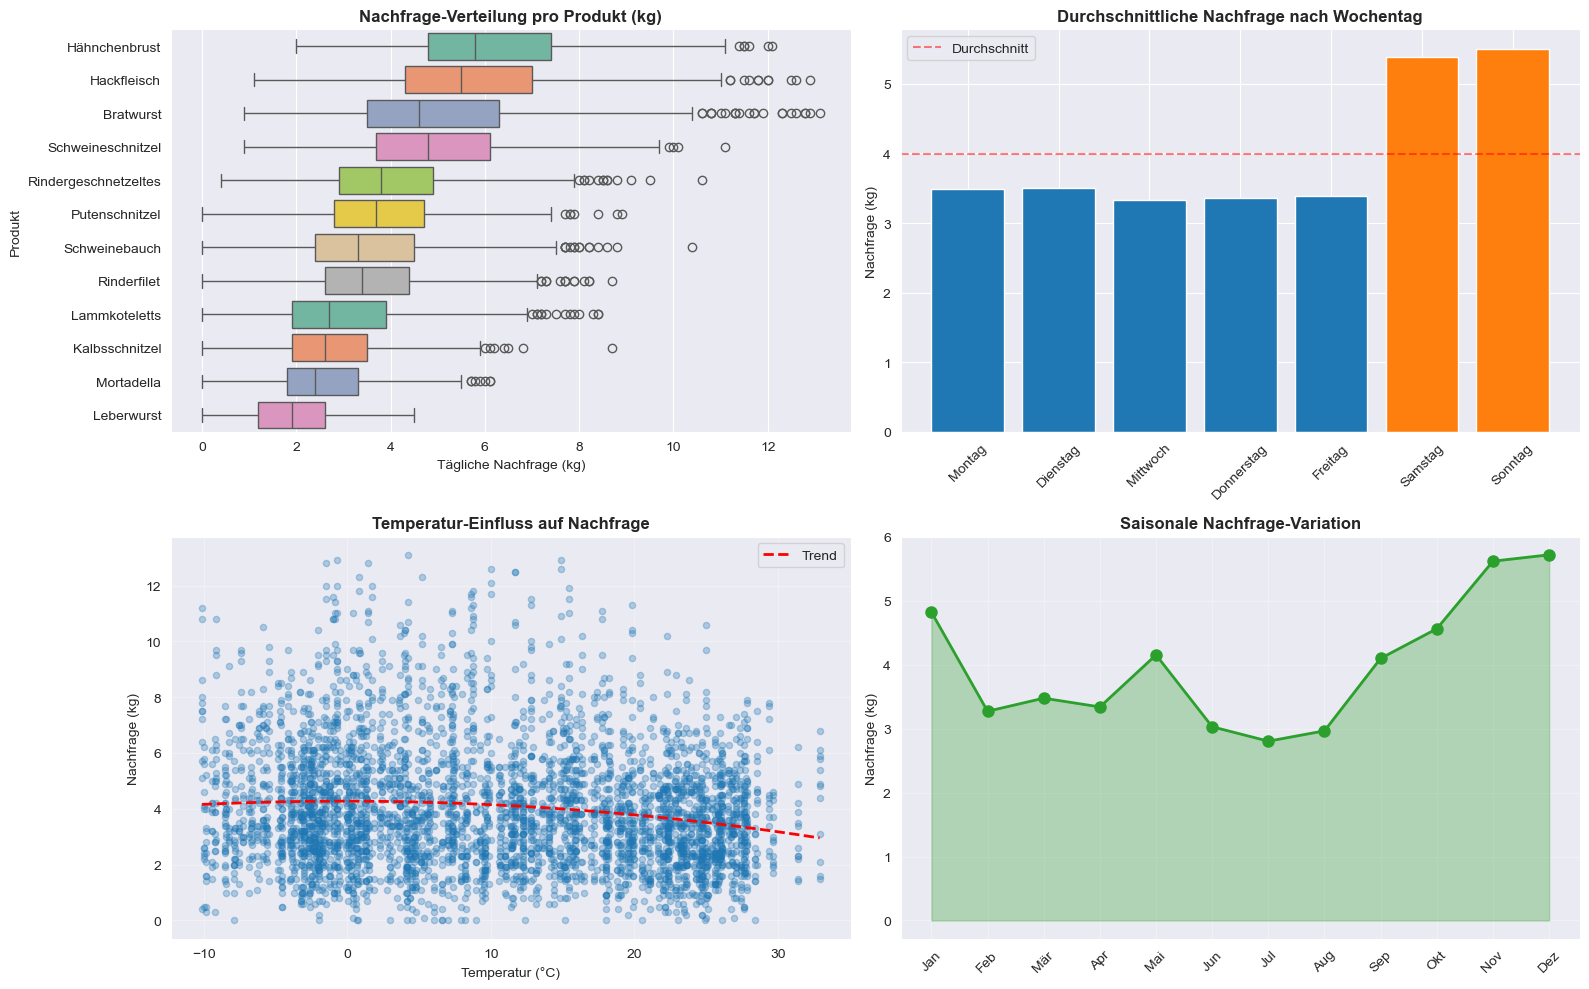

✅ Visualisierungen erstellt!


In [4]:
# Zelle 4: Visualisierungen

fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# 1. Nachfrage nach Produkt (Boxplot)
ax1 = axes[0, 0]
product_order = df.groupby('product')['demand_units'].mean().sort_values(ascending=False).index
sns.boxplot(data=df, y='product', x='demand_units', order=product_order, ax=ax1, palette='Set2')
ax1.set_title('Nachfrage-Verteilung pro Produkt (kg)', fontsize=12, fontweight='bold')
ax1.set_xlabel('Tägliche Nachfrage (kg)', fontsize=10)
ax1.set_ylabel('Produkt', fontsize=10)

# 2. Wochentag-Muster
ax2 = axes[0, 1]
weekday_data = df.groupby('weekday')['demand_units'].mean()
colors = ['#1f77b4' if i < 5 else '#ff7f0e' for i in range(7)]
ax2.bar(range(7), weekday_data.values, color=colors)
ax2.set_xticks(range(7))
ax2.set_xticklabels(weekday_names, rotation=45)
ax2.set_title('Durchschnittliche Nachfrage nach Wochentag', fontsize=12, fontweight='bold')
ax2.set_ylabel('Nachfrage (kg)', fontsize=10)
ax2.axhline(df['demand_units'].mean(), color='red', linestyle='--', alpha=0.5, label='Durchschnitt')
ax2.legend()

# 3. Temperatur-Einfluss
ax3 = axes[1, 0]
ax3.scatter(df['temperature_c'], df['demand_units'], alpha=0.3, s=20)
z = np.polyfit(df['temperature_c'].dropna(), df['demand_units'].dropna(), 2)
p = np.poly1d(z)
ax3.plot(sorted(df['temperature_c'].dropna()), p(sorted(df['temperature_c'].dropna())), "r--", linewidth=2, label='Trend')
ax3.set_title('Temperatur-Einfluss auf Nachfrage', fontsize=12, fontweight='bold')
ax3.set_xlabel('Temperatur (°C)', fontsize=10)
ax3.set_ylabel('Nachfrage (kg)', fontsize=10)
ax3.legend()
ax3.grid(True, alpha=0.3)

# 4. Saisonalität
ax4 = axes[1, 1]
monthly_data = df.groupby('month')['demand_units'].mean()
month_names = ['Jan', 'Feb', 'Mär', 'Apr', 'Mai', 'Jun', 'Jul', 'Aug', 'Sep', 'Okt', 'Nov', 'Dez']
ax4.plot(range(1, 13), monthly_data.values, marker='o', linewidth=2, markersize=8, color='#2ca02c')
ax4.fill_between(range(1, 13), monthly_data.values, alpha=0.3, color='#2ca02c')
ax4.set_xticks(range(1, 13))
ax4.set_xticklabels(month_names, rotation=45)
ax4.set_title('Saisonale Nachfrage-Variation', fontsize=12, fontweight='bold')
ax4.set_ylabel('Nachfrage (kg)', fontsize=10)
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("✅ Visualisierungen erstellt!")

### Modelltraining – Bedarfsprognose pro Produkt

Wir trainieren ein **Random Forest Regressionsmodell**, das die tägliche Nachfrage pro Produkt vorhersagt.
Das Modell kann zwischen Produkten unterscheiden und lernt individuelle Absatzmuster.

In [5]:
# Zelle 5: Features und Modell trainieren

from sklearn.preprocessing import LabelEncoder

# Produkt als numerische Feature
le_product = LabelEncoder()
df['product_encoded'] = le_product.fit_transform(df['product'])

feature_cols = [
    'weekday',
    'is_weekend',
    'month',
    'temperature_c',
    'grilling_season',
    'kale_season',
    'promo_discount_percent',
    'regular_customers_index',
    'product_encoded'
]

X = df[feature_cols]
y = df['demand_units']

# Train-Test Split (80/20)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Modell trainieren
model_forecast = RandomForestRegressor(
    n_estimators=200,
    max_depth=15,
    min_samples_split=10,
    random_state=42,
    n_jobs=-1
)

model_forecast.fit(X_train, y_train)

# Evaluierung
y_pred_train = model_forecast.predict(X_train)
y_pred_test = model_forecast.predict(X_test)

mae_train = mean_absolute_error(y_train, y_pred_train)
mae_test = mean_absolute_error(y_test, y_pred_test)
r2_train = r2_score(y_train, y_pred_train)
r2_test = r2_score(y_test, y_pred_test)

print("="*60)
print("MODELL-PERFORMANCE (Nachfrage-Prognose)")
print("="*60)
print(f"\n📈 Trainings-Daten:")
print(f"  MAE (Mean Absolute Error): {mae_train:.2f} kg")
print(f"  R² Score: {r2_train:.4f}")

print(f"\n📊 Test-Daten:")
print(f"  MAE (Mean Absolute Error): {mae_test:.2f} kg")
print(f"  R² Score: {r2_test:.4f}")

print(f"\n✅ Modell trainiert mit {len(X_train)} Trainingssamples!")

MODELL-PERFORMANCE (Nachfrage-Prognose)

📈 Trainings-Daten:
  MAE (Mean Absolute Error): 0.48 kg
  R² Score: 0.9221

📊 Test-Daten:
  MAE (Mean Absolute Error): 0.68 kg
  R² Score: 0.8499

✅ Modell trainiert mit 3513 Trainingssamples!



WICHTIGSTE EINFLUSSFAKTOREN

grilling_season             0.17% 
promo_discount_percent      0.55% 
temperature_c               3.18% █
month                       3.86% █
weekday                    10.08% █████
is_weekend                 10.26% █████
regular_customers_index    10.49% █████
kale_season                18.67% █████████
product_encoded            42.73% █████████████████████


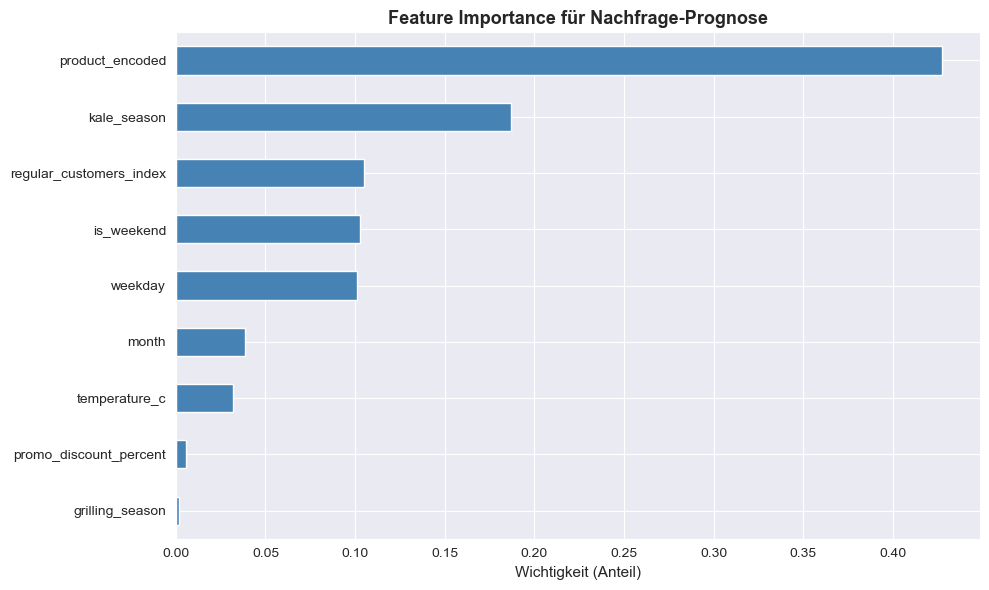

In [6]:
# Zelle 6: Feature Importance

importances = pd.Series(model_forecast.feature_importances_, index=feature_cols)
importances = importances.sort_values(ascending=True)

print("\n" + "="*60)
print("WICHTIGSTE EINFLUSSFAKTOREN")
print("="*60 + "\n")

for feature, importance in importances.items():
    pct = importance * 100
    bar = "█" * int(pct / 2)
    print(f"{feature:25s} {pct:6.2f}% {bar}")

# Visualisierung
fig, ax = plt.subplots(figsize=(10, 6))
importances.plot(kind='barh', ax=ax, color='steelblue')
ax.set_xlabel('Wichtigkeit (Anteil)', fontsize=11)
ax.set_title('Feature Importance für Nachfrage-Prognose', fontsize=13, fontweight='bold')
plt.tight_layout()
plt.show()

### Prognose-Funktion für die nächsten 14 Tage

Wir definieren eine Funktion, die für ein Beispiel-Szenario die Nachfrage der nächsten 14 Tage vorhersagt.

In [7]:
# Zelle 7: Prognose-Funktion

def forecast_next_14_days(model, start_date, products_list, regular_customers_index=0.85):
    """
    Erzeugt eine 14-Tage-Prognose für alle Produkte.
    
    Parameter:
    - model: Trainiertes Regressionsmodell
    - start_date: Startdatum (datetime)
    - products_list: Liste der Produkte
    - regular_customers_index: Stammkundenzahl (0.5-1.0)
    """
    
    forecast_rows = []
    
    for day_offset in range(14):
        current_date = start_date + pd.Timedelta(days=day_offset)
        weekday = current_date.weekday()
        is_weekend = 1 if weekday >= 5 else 0
        month = current_date.month
        day_of_year = current_date.timetuple().tm_yday
        
        # Basis-Features
        temp = 10 + 15 * np.sin(2 * np.pi * day_of_year / 365)
        grilling_season = 1 if month in [5, 6, 7, 8, 9] else 0.8
        kale_season = 1 if month in [10, 11, 12, 1] else 0.7
        promo = np.random.choice([0, 5, 10])
        
        for product in products_list:
            product_encoded = le_product.transform([product])[0]
            
            # Prediction
            features = np.array([[
                weekday, is_weekend, month, temp,
                grilling_season, kale_season, promo,
                regular_customers_index, product_encoded
            ]])
            
            forecast = model.predict(features)[0]
            forecast = max(0, forecast)  # Keine negativen Werte
            
            forecast_rows.append({
                'date': current_date,
                'weekday_name': weekday_names[weekday],
                'product': product,
                'forecast_units': round(forecast, 1),
                'temperature': round(temp, 1)
            })
    
    return pd.DataFrame(forecast_rows)

# Prognose erzeugen
start_date_forecast = pd.Timestamp('2025-01-15')
products_list = df['product'].unique().tolist()

forecast_df = forecast_next_14_days(
    model_forecast,
    start_date_forecast,
    products_list,
    regular_customers_index=0.90
)

print("✅ 14-Tage-Prognose erstellt!")
print("\nAuszug der ersten 5 Tage:")
print(forecast_df.head(12).to_string(index=False))

✅ 14-Tage-Prognose erstellt!

Auszug der ersten 5 Tage:
      date weekday_name              product  forecast_units  temperature
2025-01-15     Mittwoch    Schweineschnitzel             5.7         13.8
2025-01-15     Mittwoch          Rinderfilet             4.2         13.8
2025-01-15     Mittwoch        Hähnchenbrust             7.0         13.8
2025-01-15     Mittwoch            Bratwurst             5.0         13.8
2025-01-15     Mittwoch           Leberwurst             2.7         13.8
2025-01-15     Mittwoch           Mortadella             2.9         13.8
2025-01-15     Mittwoch Rindergeschnetzeltes             4.4         13.8
2025-01-15     Mittwoch        Lammkoteletts             2.9         13.8
2025-01-15     Mittwoch          Hackfleisch             6.5         13.8
2025-01-15     Mittwoch        Schweinebauch             3.9         13.8
2025-01-15     Mittwoch       Putenschnitzel             4.3         13.8
2025-01-15     Mittwoch       Kalbsschnitzel            

### Wirtschaftliche Betrachtung

Aus der Prognose leiten wir **Materialeinsatz, erwarteten Umsatz und Gewinn** pro Produkt ab.

In [8]:
# Zelle 8: Wirtschaftliche Kennzahlen

# Kostenstruktur pro Produkt (€ pro kg)
cost_structure = {
    'Schweineschnitzel': {'cost': 3.50, 'price': 8.99},
    'Rinderfilet': {'cost': 6.00, 'price': 15.99},
    'Hähnchenbrust': {'cost': 2.50, 'price': 6.99},
    'Bratwurst': {'cost': 2.80, 'price': 7.99},
    'Leberwurst': {'cost': 1.80, 'price': 5.99},
    'Mortadella': {'cost': 2.00, 'price': 6.99},
    'Rindergeschnetzeltes': {'cost': 4.50, 'price': 11.99},
    'Lammkoteletts': {'cost': 5.50, 'price': 14.99},
    'Hackfleisch': {'cost': 3.00, 'price': 7.99},
    'Schweinebauch': {'cost': 2.20, 'price': 5.99},
    'Putenschnitzel': {'cost': 3.00, 'price': 8.99},
    'Kalbsschnitzel': {'cost': 5.00, 'price': 12.99}
}

# Kosten und Erlöse berechnen
forecast_df['unit_cost'] = forecast_df['product'].map(lambda p: cost_structure[p]['cost'])
forecast_df['unit_price'] = forecast_df['product'].map(lambda p: cost_structure[p]['price'])
forecast_df['material_cost_eur'] = (forecast_df['forecast_units'] * forecast_df['unit_cost']).round(2)
forecast_df['expected_revenue_eur'] = (forecast_df['forecast_units'] * forecast_df['unit_price']).round(2)
forecast_df['expected_profit_eur'] = (forecast_df['expected_revenue_eur'] - forecast_df['material_cost_eur']).round(2)
forecast_df['margin_percent'] = ((forecast_df['expected_profit_eur'] / forecast_df['expected_revenue_eur']) * 100).round(1)

print("="*80)
print("WIRTSCHAFTLICHE PROGNOSE - NÄCHSTE 14 TAGE")
print("="*80)

# Zusammenfassung pro Produkt
product_summary = forecast_df.groupby('product').agg({
    'forecast_units': 'sum',
    'material_cost_eur': 'sum',
    'expected_revenue_eur': 'sum',
    'expected_profit_eur': 'sum'
}).round(2)

product_summary['margin_percent'] = ((product_summary['expected_profit_eur'] / product_summary['expected_revenue_eur']) * 100).round(1)
product_summary = product_summary.sort_values('expected_profit_eur', ascending=False)

print("\n📊 Prognose pro Produkt (14 Tage):")
print(product_summary.to_string())

# Gesamtsicht
print("\n" + "-"*80)
total_units = forecast_df['forecast_units'].sum()
total_costs = forecast_df['material_cost_eur'].sum()
total_revenue = forecast_df['expected_revenue_eur'].sum()
total_profit = forecast_df['expected_profit_eur'].sum()
total_margin = (total_profit / total_revenue * 100) if total_revenue > 0 else 0

print(f"\n🎯 GESAMTPROGNOSE (14 Tage):")
print(f"  Erwartete Menge:    {total_units:>10.1f} kg")
print(f"  Materialkosten:     {total_costs:>10.2f} €")
print(f"  Erwarteter Erlös:   {total_revenue:>10.2f} €")
print(f"  Erwarteter Gewinn:  {total_profit:>10.2f} €")
print(f"  Gewinnmarge:        {total_margin:>10.1f} %")
print("\n" + "="*80)

WIRTSCHAFTLICHE PROGNOSE - NÄCHSTE 14 TAGE

📊 Prognose pro Produkt (14 Tage):
                      forecast_units  material_cost_eur  expected_revenue_eur  expected_profit_eur  margin_percent
product                                                                                                           
Rinderfilet                     69.5             417.00               1111.35               694.35            62.5
Lammkoteletts                   57.6             316.80                863.42               546.62            63.3
Rindergeschnetzeltes            71.9             323.55                862.08               538.53            62.5
Hackfleisch                    104.7             314.10                836.59               522.49            62.5
Schweineschnitzel               92.4             323.40                830.64               507.24            61.1
Hähnchenbrust                  107.2             268.00                749.30               481.30            64.2
Br

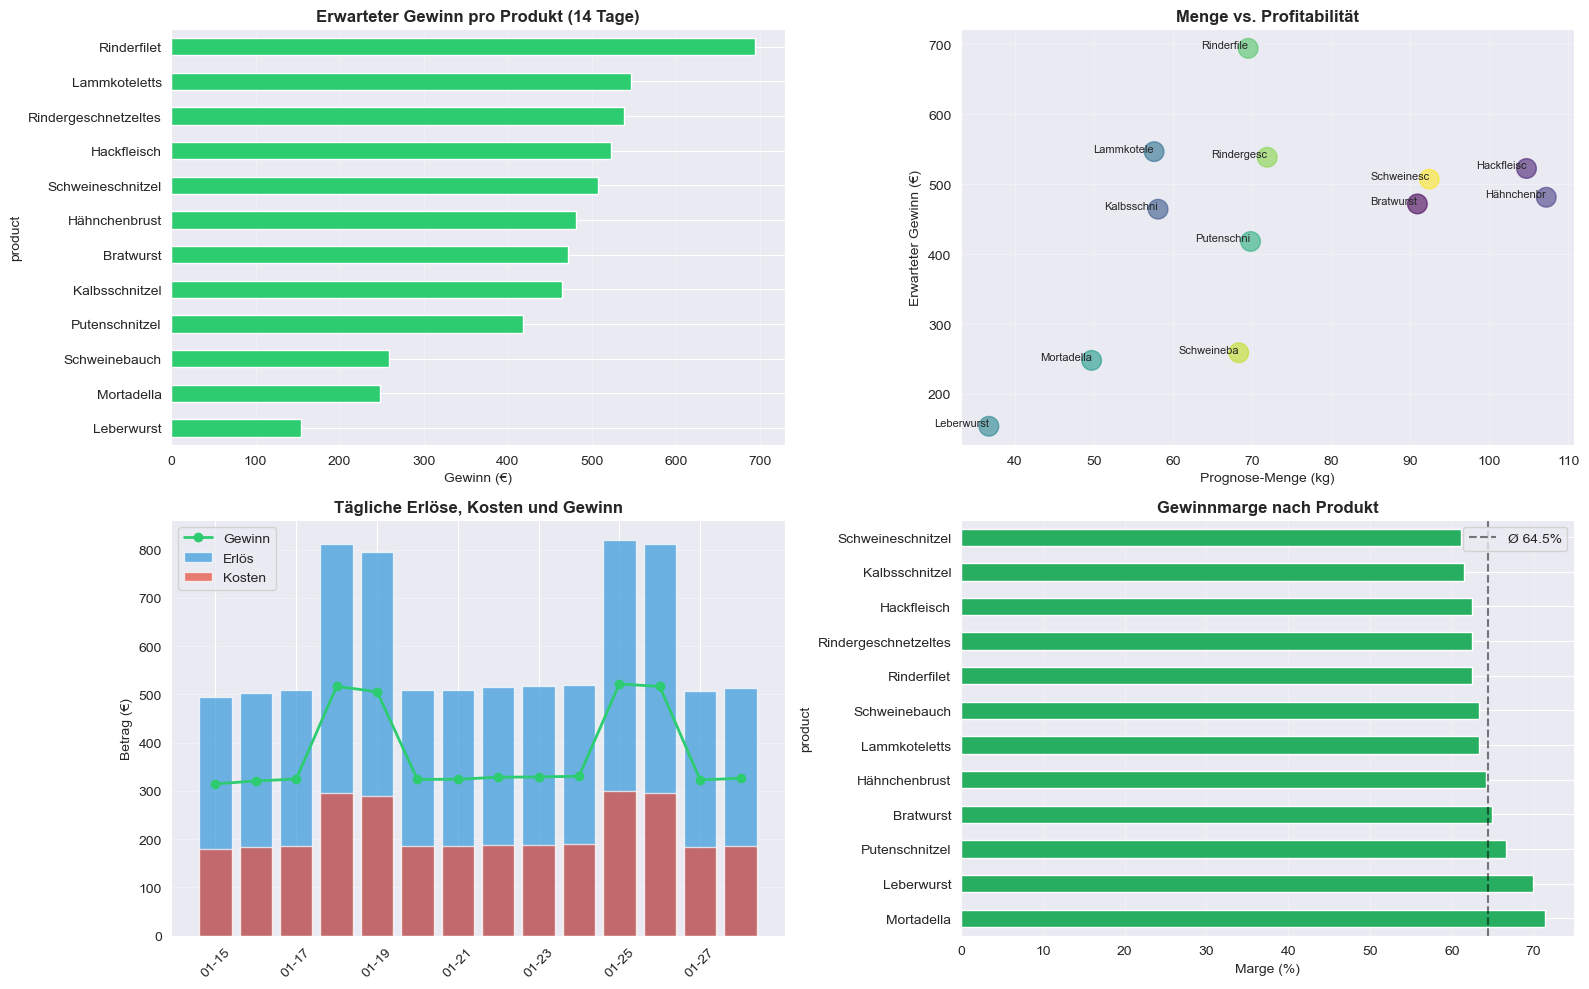

✅ Wirtschaftliche Visualisierungen erstellt!


In [9]:
# Zelle 9: Visualisierung der wirtschaftlichen Prognose

fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# 1. Erwartete Gewinne pro Produkt
ax1 = axes[0, 0]
profit_by_product = forecast_df.groupby('product')['expected_profit_eur'].sum().sort_values(ascending=True)
colors_profit = ['#2ecc71' if x > 0 else '#e74c3c' for x in profit_by_product.values]
profit_by_product.plot(kind='barh', ax=ax1, color=colors_profit)
ax1.set_title('Erwarteter Gewinn pro Produkt (14 Tage)', fontsize=12, fontweight='bold')
ax1.set_xlabel('Gewinn (€)', fontsize=10)
ax1.grid(axis='x', alpha=0.3)

# 2. Menge vs. Gewinn Scatter
ax2 = axes[0, 1]
product_stats = forecast_df.groupby('product').agg({'forecast_units': 'sum', 'expected_profit_eur': 'sum'})
ax2.scatter(product_stats['forecast_units'], product_stats['expected_profit_eur'], s=200, alpha=0.6, c=range(len(product_stats)), cmap='viridis')
for product, row in product_stats.iterrows():
    ax2.annotate(product[:10], (row['forecast_units'], row['expected_profit_eur']), fontsize=8, ha='right')
ax2.set_title('Menge vs. Profitabilität', fontsize=12, fontweight='bold')
ax2.set_xlabel('Prognose-Menge (kg)', fontsize=10)
ax2.set_ylabel('Erwarteter Gewinn (€)', fontsize=10)
ax2.grid(True, alpha=0.3)

# 3. Täglicher Erlös über 14 Tage
ax3 = axes[1, 0]
daily_revenue = forecast_df.groupby('date')['expected_revenue_eur'].sum()
daily_costs = forecast_df.groupby('date')['material_cost_eur'].sum()
daily_profit = daily_revenue - daily_costs

ax3.bar(range(len(daily_revenue)), daily_revenue.values, label='Erlös', alpha=0.7, color='#3498db')
ax3.bar(range(len(daily_costs)), daily_costs.values, label='Kosten', alpha=0.7, color='#e74c3c')
ax3.plot(range(len(daily_profit)), daily_profit.values, marker='o', label='Gewinn', color='#2ecc71', linewidth=2, markersize=6)
ax3.set_xticks(range(0, len(daily_revenue), 2))
ax3.set_xticklabels([d.strftime('%m-%d') for d in daily_revenue.index[::2]], rotation=45)
ax3.set_title('Tägliche Erlöse, Kosten und Gewinn', fontsize=12, fontweight='bold')
ax3.set_ylabel('Betrag (€)', fontsize=10)
ax3.legend(loc='upper left')
ax3.grid(axis='y', alpha=0.3)

# 4. Gewinnmarge pro Produkt
ax4 = axes[1, 1]
margin_by_product = forecast_df.groupby('product').apply(
    lambda x: ((x['expected_profit_eur'].sum() / x['expected_revenue_eur'].sum()) * 100) if x['expected_revenue_eur'].sum() > 0 else 0
).sort_values(ascending=False)
colors_margin = ['#27ae60' if x > 40 else '#f39c12' if x > 30 else '#e74c3c' for x in margin_by_product.values]
margin_by_product.plot(kind='barh', ax=ax4, color=colors_margin)
ax4.set_title('Gewinnmarge nach Produkt', fontsize=12, fontweight='bold')
ax4.set_xlabel('Marge (%)', fontsize=10)
ax4.axvline(margin_by_product.mean(), color='black', linestyle='--', alpha=0.5, label=f'Ø {margin_by_product.mean():.1f}%')
ax4.legend()
ax4.grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()

print("✅ Wirtschaftliche Visualisierungen erstellt!")

---

## Modul 2 – Predictive Maintenance für Kühlvitrinen und Fleischmaschinen 🔧❄️

Jetzt betrachten wir die **kritischen Geräte** der Metzgerei mit Sensordaten:

### Überwachte Geräte:
1. Großvitrinen (Fleischtheke)
2. Fleischmaschine (Slicer)
3. Hackmaschine
4. Kühlkammer

**Überwachte Sensoren:**
- Temperatur (Sollwert vs. Istwert)
- Vibration (Abnutzung)
- Stromverbrauch (Anomalien)
- Laufzeit (Betriebsstunden)
- Wartungshistorie

In [10]:
# Zelle 10: Synthetische Sensordaten für Geräte erzeugen

np.random.seed(123)

num_days = 200
devices = ['Großvitrine_1', 'Großvitrine_2', 'Fleischmaschine', 'Hackmaschine', 'Kühlkammer']

dates_maint = pd.date_range(start="2024-04-01", periods=num_days, freq="D")

rows_maint = []

for device_id in devices:
    # Unterschiedliche Fehlerprofile pro Gerätetyp
    if 'Vitrine' in device_id:
        failure_threshold = 0.3  # Höheres Fehlerrisiko
        base_vibration = 2.5
        base_power = 150
    elif device_id == 'Fleischmaschine':
        failure_threshold = 0.25
        base_vibration = 4.0
        base_power = 200
    elif device_id == 'Hackmaschine':
        failure_threshold = 0.20
        base_vibration = 3.5
        base_power = 180
    else:  # Kühlkammer
        failure_threshold = 0.15
        base_vibration = 1.5
        base_power = 250
    
    days_since_maintenance = 0
    
    for day_idx, date in enumerate(dates_maint):
        days_since_maintenance += 1
        
        # Normaltemperatur
        normal_temp = -5 if 'Vitrine' in device_id or 'Kühlkammer' in device_id else 25
        temp_deviation = np.random.normal(0, 1) + (days_since_maintenance / 100)  # Drift über Zeit
        
        # Vibration erhöht sich mit Betriebszeit
        vibration = base_vibration + (days_since_maintenance / 50) + np.random.normal(0, 0.5)
        
        # Stromverbrauch
        power = base_power + np.random.normal(0, 20) + (days_since_maintenance / 80) * 10
        
        # Betriebsstunden (ca. 12h/Tag)
        operating_hours = day_idx * 12
        
        # Fehlerwahrscheinlichkeit steigt mit Zeit seit letzter Wartung
        failure_probability = min(
            failure_threshold + (days_since_maintenance / 200),
            0.95
        )
        
        # Fehler simulieren (binär)
        has_failure = 1 if np.random.random() < failure_probability else 0
        
        # Wartung durchführen wenn Fehler oder zu lange her
        if has_failure or days_since_maintenance > 60:
            days_since_maintenance = 0
        
        rows_maint.append({
            'date': date,
            'device': device_id,
            'temp_deviation_c': temp_deviation,
            'vibration_level': vibration,
            'power_consumption_w': power,
            'operating_hours': operating_hours,
            'days_since_maintenance': days_since_maintenance,
            'failure_risk': failure_probability,
            'has_failure': has_failure
        })

df_maint = pd.DataFrame(rows_maint)

print("✅ Maintenance-Datensatz erstellt:")
print(f"   Geräte: {df_maint['device'].nunique()}")
print(f"   Datenpunkte: {len(df_maint)}")
print(f"   Zeitraum: {df_maint['date'].min().date()} bis {df_maint['date'].max().date()}")
print(f"   Fehler gesamt: {df_maint['has_failure'].sum()}")

✅ Maintenance-Datensatz erstellt:
   Geräte: 5
   Datenpunkte: 1000
   Zeitraum: 2024-04-01 bis 2024-10-17
   Fehler gesamt: 222


In [11]:
# Zelle 11: Klassifikationsmodell für Ausfallrisiko trainieren

from sklearn.preprocessing import LabelEncoder

le_device = LabelEncoder()
df_maint['device_encoded'] = le_device.fit_transform(df_maint['device'])

feature_cols_maint = [
    'temp_deviation_c',
    'vibration_level',
    'power_consumption_w',
    'operating_hours',
    'days_since_maintenance',
    'device_encoded'
]

X_m = df_maint[feature_cols_maint]
y_m = df_maint['has_failure']

# Train-Test Split
X_train_m, X_test_m, y_train_m, y_test_m = train_test_split(
    X_m, y_m, test_size=0.25, random_state=42, stratify=y_m
)

# Klassifikationsmodell
clf = RandomForestClassifier(
    n_estimators=150,
    max_depth=12,
    min_samples_split=8,
    class_weight='balanced',
    random_state=42,
    n_jobs=-1
)

clf.fit(X_train_m, y_train_m)

# Evaluierung
y_pred_m = clf.predict(X_test_m)
y_pred_proba_m = clf.predict_proba(X_test_m)[:, 1]

print("="*60)
print("MODELL-PERFORMANCE (Ausfallrisiko-Klassifikation)")
print("="*60)

print("\n" + classification_report(y_test_m, y_pred_m, target_names=['Kein Fehler', 'Fehler']))

from sklearn.metrics import roc_auc_score, roc_curve
auc_score = roc_auc_score(y_test_m, y_pred_proba_m)
print(f"\n📊 ROC-AUC Score: {auc_score:.4f}")
print(f"✅ Modell erfolgreich trainiert!")

MODELL-PERFORMANCE (Ausfallrisiko-Klassifikation)

              precision    recall  f1-score   support

 Kein Fehler       1.00      1.00      1.00       195
      Fehler       1.00      1.00      1.00        55

    accuracy                           1.00       250
   macro avg       1.00      1.00      1.00       250
weighted avg       1.00      1.00      1.00       250


📊 ROC-AUC Score: 1.0000
✅ Modell erfolgreich trainiert!


In [12]:
# Zelle 12: Maintenance Assessment Funktion

def maintenance_risk_assessment(
    device_id,
    temp_deviation_c,
    vibration_level,
    power_consumption_w,
    operating_hours,
    days_since_maintenance,
    model=clf,
    threshold=0.5
):
    """
    Bewertet Ausfallrisiko basierend auf aktuellen Sensordaten.
    Gibt Wartungsempfehlung aus.
    """
    
    device_encoded = le_device.transform([device_id])[0]
    
    features = np.array([[
        temp_deviation_c,
        vibration_level,
        power_consumption_w,
        operating_hours,
        days_since_maintenance,
        device_encoded
    ]])
    
    # Vorhersage
    risk_probability = model.predict_proba(features)[0][1]  # Wahrscheinlichkeit für Fehler
    prediction = "WARTUNG NÖTIG" if risk_probability >= threshold else "OK"
    
    # Priorität basierend auf Wahrscheinlichkeit
    if risk_probability > 0.8:
        priority = "🔴 KRITISCH"
        recommendation = "Sofort Wartung durchführen!"
    elif risk_probability > 0.6:
        priority = "🟠 HOCH"
        recommendation = "Wartung in den nächsten 2-3 Tagen planen"
    elif risk_probability > threshold:
        priority = "🟡 MITTEL"
        recommendation = "Wartung in dieser Woche planen"
    else:
        priority = "🟢 GUT"
        recommendation = "Regelmäßig überwachen, kein sofortiges Handeln nötig"
    
    return {
        'device': device_id,
        'risk_probability': round(risk_probability * 100, 1),
        'priority': priority,
        'prediction': prediction,
        'recommendation': recommendation
    }

# Test-Szenarien
print("="*80)
print("AKTUELLE WARTUNGS-ASSESSMENTS")
print("="*80)

test_scenarios = [
    {
        'device': 'Großvitrine_1',
        'temp_deviation_c': 3.5,
        'vibration_level': 2.1,
        'power_consumption_w': 155,
        'operating_hours': 1200,
        'days_since_maintenance': 45
    },
    {
        'device': 'Fleischmaschine',
        'temp_deviation_c': -0.2,
        'vibration_level': 5.8,
        'power_consumption_w': 210,
        'operating_hours': 2400,
        'days_since_maintenance': 58
    },
    {
        'device': 'Hackmaschine',
        'temp_deviation_c': 1.2,
        'vibration_level': 3.2,
        'power_consumption_w': 185,
        'operating_hours': 1800,
        'days_since_maintenance': 15
    },
    {
        'device': 'Kühlkammer',
        'temp_deviation_c': -1.5,
        'vibration_level': 1.8,
        'power_consumption_w': 245,
        'operating_hours': 3000,
        'days_since_maintenance': 30
    }
]

for scenario in test_scenarios:
    result = maintenance_risk_assessment(
        device_id=scenario['device'],
        temp_deviation_c=scenario['temp_deviation_c'],
        vibration_level=scenario['vibration_level'],
        power_consumption_w=scenario['power_consumption_w'],
        operating_hours=scenario['operating_hours'],
        days_since_maintenance=scenario['days_since_maintenance']
    )
    
    print(f"\n{result['priority']} {result['device']}")
    print(f"  Ausfallrisiko: {result['risk_probability']}%")
    print(f"  Status: {result['prediction']}")
    print(f"  Empfehlung: {result['recommendation']}")
    print("-" * 80)

AKTUELLE WARTUNGS-ASSESSMENTS

🟢 GUT Großvitrine_1
  Ausfallrisiko: 2.7%
  Status: OK
  Empfehlung: Regelmäßig überwachen, kein sofortiges Handeln nötig
--------------------------------------------------------------------------------

🟢 GUT Fleischmaschine
  Ausfallrisiko: 7.1%
  Status: OK
  Empfehlung: Regelmäßig überwachen, kein sofortiges Handeln nötig
--------------------------------------------------------------------------------

🟢 GUT Hackmaschine
  Ausfallrisiko: 1.8%
  Status: OK
  Empfehlung: Regelmäßig überwachen, kein sofortiges Handeln nötig
--------------------------------------------------------------------------------

🟢 GUT Kühlkammer
  Ausfallrisiko: 2.9%
  Status: OK
  Empfehlung: Regelmäßig überwachen, kein sofortiges Handeln nötig
--------------------------------------------------------------------------------


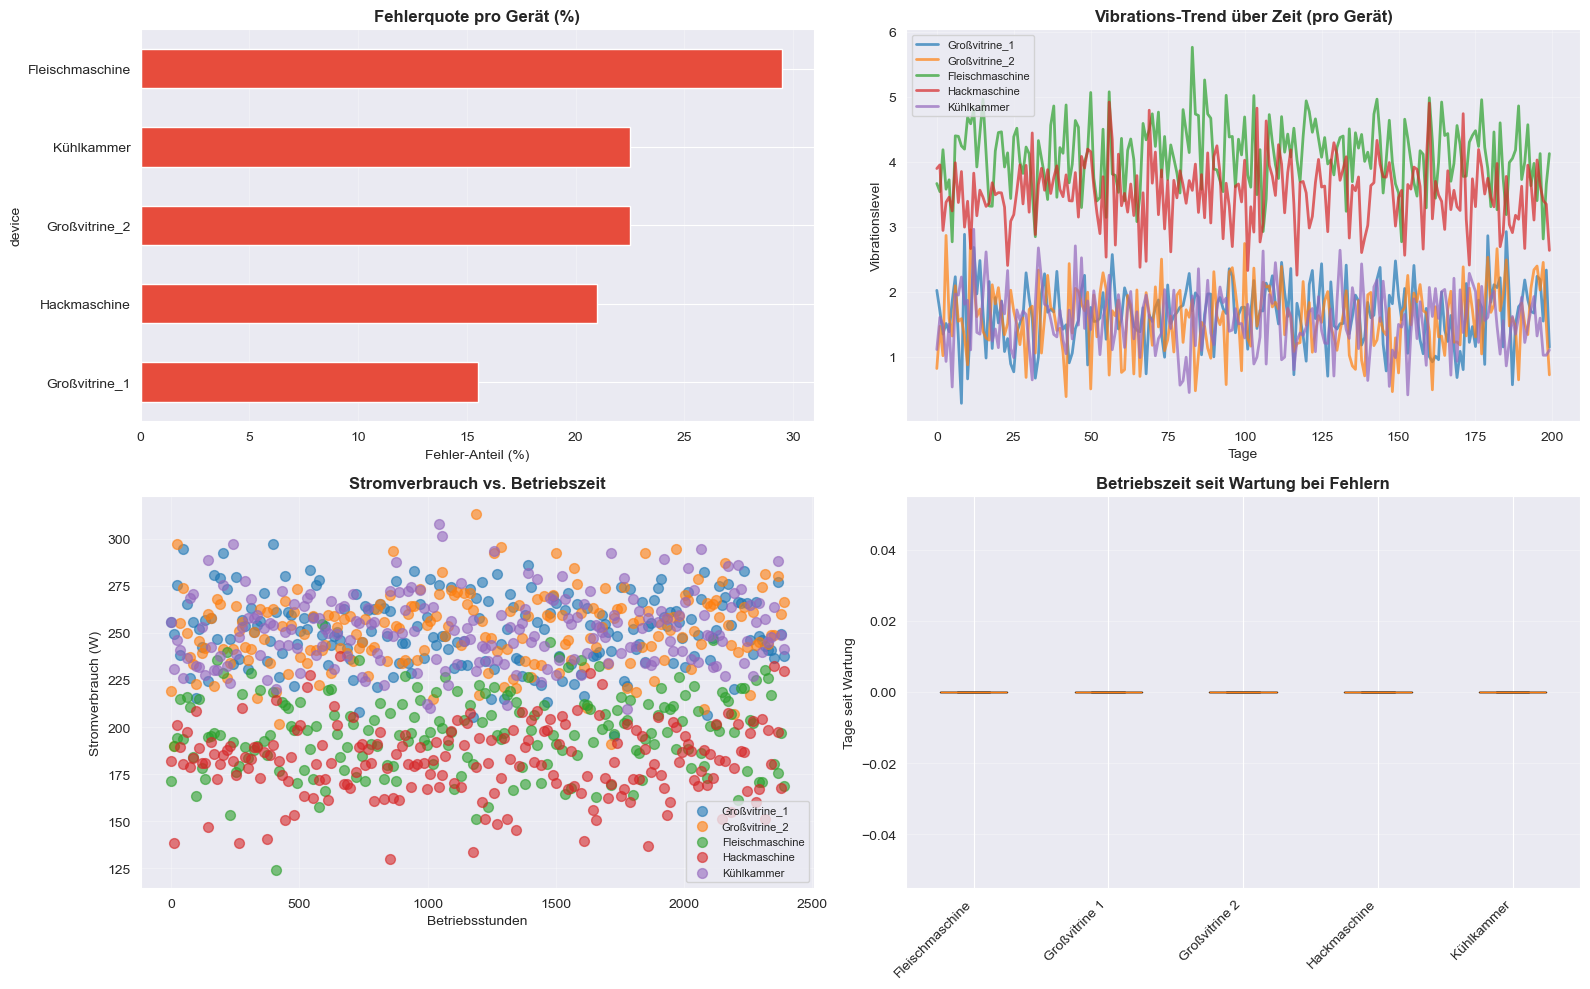

✅ Maintenance-Visualisierungen erstellt!


In [13]:
# Zelle 13: Maintenance Visualisierungen

fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# 1. Fehlerquote pro Gerät
ax1 = axes[0, 0]
error_rates = df_maint.groupby('device')['has_failure'].agg(['sum', 'count'])
error_rates['rate'] = (error_rates['sum'] / error_rates['count'] * 100).round(1)
error_rates_sorted = error_rates.sort_values('rate', ascending=True)
colors_error = ['#e74c3c' if x > 15 else '#f39c12' if x > 10 else '#2ecc71' for x in error_rates_sorted['rate'].values]
error_rates_sorted['rate'].plot(kind='barh', ax=ax1, color=colors_error)
ax1.set_title('Fehlerquote pro Gerät (%)', fontsize=12, fontweight='bold')
ax1.set_xlabel('Fehler-Anteil (%)', fontsize=10)
ax1.grid(axis='x', alpha=0.3)

# 2. Vibration vs. Fehler Trend
ax2 = axes[0, 1]
for device in df_maint['device'].unique():
    device_data = df_maint[df_maint['device'] == device].sort_values('date')
    ax2.plot(range(len(device_data)), device_data['vibration_level'].values, label=device, linewidth=2, alpha=0.7)
ax2.set_title('Vibrations-Trend über Zeit (pro Gerät)', fontsize=12, fontweight='bold')
ax2.set_xlabel('Tage', fontsize=10)
ax2.set_ylabel('Vibrationslevel', fontsize=10)
ax2.legend(loc='best', fontsize=8)
ax2.grid(True, alpha=0.3)

# 3. Stromverbrauch vs. Betriebszeit
ax3 = axes[1, 0]
for device in df_maint['device'].unique():
    device_data = df_maint[df_maint['device'] == device]
    ax3.scatter(device_data['operating_hours'], device_data['power_consumption_w'], label=device, alpha=0.6, s=50)
ax3.set_title('Stromverbrauch vs. Betriebszeit', fontsize=12, fontweight='bold')
ax3.set_xlabel('Betriebsstunden', fontsize=10)
ax3.set_ylabel('Stromverbrauch (W)', fontsize=10)
ax3.legend(loc='best', fontsize=8)
ax3.grid(True, alpha=0.3)

# 4. Tage seit Wartung bei Fehlern
ax4 = axes[1, 1]
failure_data = df_maint[df_maint['has_failure'] == 1]
maintenance_history = failure_data.groupby('device')['days_since_maintenance'].apply(list)
device_names = [d.replace('_', ' ') for d in maintenance_history.index]
ax4.boxplot(maintenance_history.values, labels=device_names)
ax4.set_title('Betriebszeit seit Wartung bei Fehlern', fontsize=12, fontweight='bold')
ax4.set_ylabel('Tage seit Wartung', fontsize=10)
ax4.grid(axis='y', alpha=0.3)
plt.setp(ax4.xaxis.get_majorticklabels(), rotation=45, ha='right')

plt.tight_layout()
plt.show()

print("✅ Maintenance-Visualisierungen erstellt!")

---

## 📊 FAZIT – Smart Butcher KI-System

Wir haben zwei produktionsrelevante KI-Module für eine Metzgerei gebaut:

### ✅ Modul 1: Bedarfsprognose
- **Prognose für 12+ Fleischprodukte** mit täglicher Auflösung
- **Berücksichtigung von:**
  - Saisonalität (Grillsaison, Grünkohl-Saison)
  - Wochentag-Muster (Wochenende vs. Wochentag)
  - Temperatur-Einfluss
  - Promotionen und Stammkundenzahl
- **Wirtschaftliche Kennzahlen:** Kosten, Erlöse, Gewinnmarge pro Produkt

### ✅ Modul 2: Predictive Maintenance
- **Überwachung von 5 kritischen Geräten** (Vitrinen, Maschinen, Kühlkammer)
- **Echtzeitrisiko-Bewertung** basierend auf:
  - Temperaturabweichungen
  - Vibrationspegel (Abnutzung)
  - Stromverbrauch-Anomalien
  - Betriebszeit und Wartungshistorie
- **Priorisierte Wartungsempfehlungen** (Kritisch → Gut)

### 🚀 Business-Nutzen
- **Materialplanung & Lagerhaltung:** Weniger Ausschuss, bessere Frischheit
- **Umsatzoptimierung:** Data-driven Pricing und Promotion-Planung
- **Kostenersparnis:** Preventive Maintenance statt Notfall-Reparaturen
- **Verfügbarkeit:** Geplante Wartung = keine überraschenden Ausfallzeiten

---